<a href="https://colab.research.google.com/github/olley102/CommunityDetectionURSS/blob/main/gpw_optical_flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optical flow applied to GPWv411 Population Count dataset.

## 1. Load GPW rectangles from GDrive

In [1]:
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!ls '/content/drive/My Drive/GoogleEarthEngine'

GPW_v411_pc_time0.tif  GPW_v411_pc_time2.tif  GPW_v411_pc_time4.tif
GPW_v411_pc_time1.tif  GPW_v411_pc_time3.tif


In [4]:
import rasterio

In [5]:
import numpy as np

In [6]:
with rasterio.open('/content/drive/My Drive/GoogleEarthEngine/GPW_v411_pc_time0.tif', 'r') as ds:
  time0 = ds.read()

gpw = np.zeros((time0.shape[1], time0.shape[2], 5), dtype='float')
gpw[..., 0] = time0[0]

for i in range(4):
  with rasterio.open(f'/content/drive/My Drive/GoogleEarthEngine/GPW_v411_pc_time{i+1}.tif', 'r') as ds:
    gpw[..., i+1] = ds.read()[0]

gpw[np.isnan(gpw)] = 0.0

In [7]:
import matplotlib.pyplot as plt

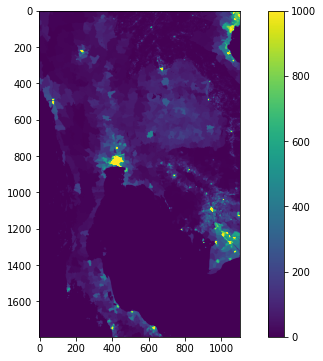

In [8]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot()
im = ax.imshow(gpw[..., 0], vmin=0, vmax=1000)
fig.colorbar(im, ax=ax)
fig.show()

## 2. Optical flow iteration

In [9]:
!git clone https://github.com/olley102/CommunityDetectionURSS.git

fatal: destination path 'CommunityDetectionURSS' already exists and is not an empty directory.


In [10]:
import sys
sys.path.append('/content/CommunityDetectionURSS')

In [11]:
from image_processing import optical_flow

In [12]:
uv = optical_flow.iteration(gpw, 1, alpha=10, use_previous=True, centering=(0, 0, 0))

In [13]:
uv.shape

(2, 1796, 1105, 5)

## 3. Plot vector field

In [14]:
threshold = 0.9999

In [15]:
mag = uv[0]**2 + uv[1]**2
mask = mag >= np.quantile(mag, threshold, axis=(0, 1))

In [16]:
mask.shape

(1796, 1105, 5)

In [17]:
uv_th = uv[:, mask]

In [18]:
uv_th.shape

(2, 995)

In [19]:
X = np.array(np.where(mask))

In [20]:
X_frames = [X[:-1, X[2] == i] for i in range(5)]

In [21]:
uv_th_frames = [uv_th[:, X[2] == i] for i in range(5)]

In [22]:
years = ['2000', '2005', '2010', '2015', '2020']

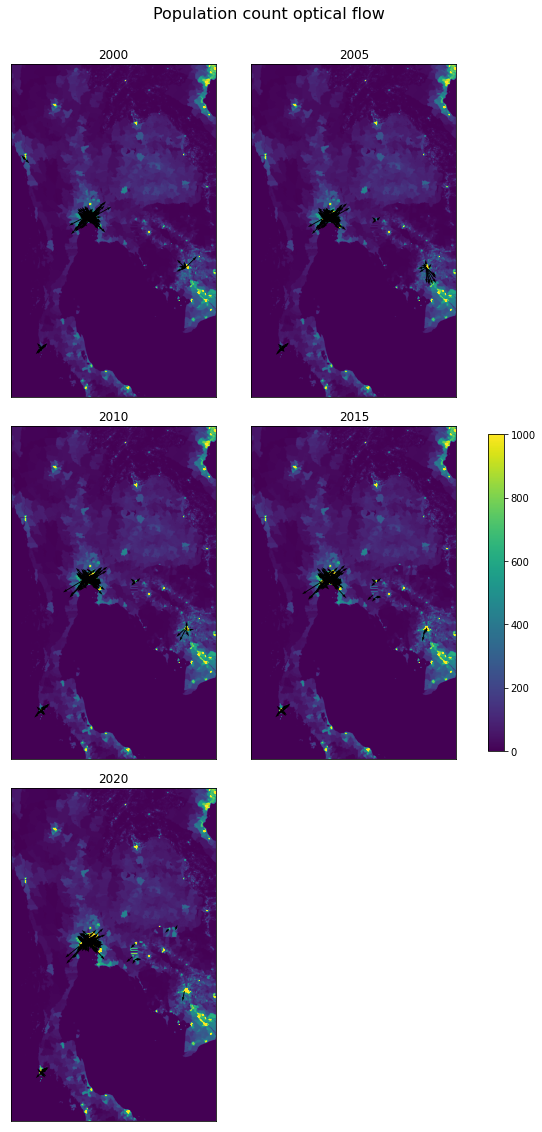

In [23]:
fig = plt.figure(figsize=(9, 16))
fig.suptitle('Population count optical flow', fontsize=16)

axes = []

for i in range(5):
  axes.append(fig.add_subplot(3, 2, i+1))
  im = axes[i].imshow(gpw[..., i], vmin=0, vmax=1000)
  axes[i].xaxis.set_visible(False)
  axes[i].yaxis.set_visible(False)
  plt.quiver(X_frames[i][1,:], X_frames[i][0,:], *uv_th_frames[i])
  axes[i].set_title(years[i])

fig.tight_layout()
plt.subplots_adjust(top=0.93)
fig.colorbar(im, ax=axes, shrink=0.3)

In [24]:
def divergence(f):
  return np.sum(np.gradient(f, axis=0), axis=0)

In [25]:
uv_div = divergence(uv)

In [26]:
uv_div.shape

(1796, 1105, 5)

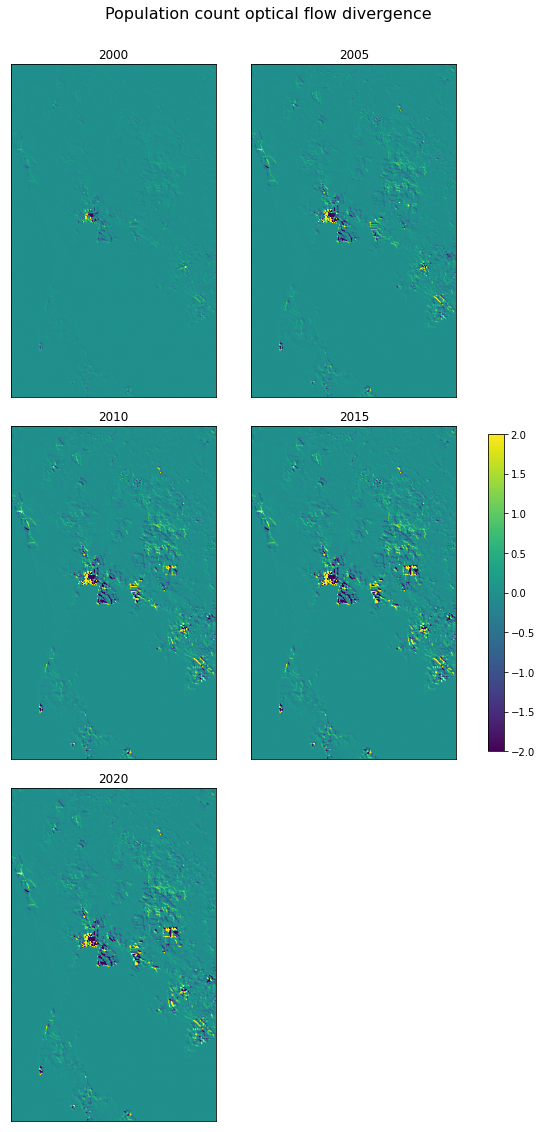

In [30]:
fig = plt.figure(figsize=(9, 16))
fig.suptitle('Population count optical flow divergence', fontsize=16)

axes = []

for i in range(5):
  axes.append(fig.add_subplot(3, 2, i+1))
  im = axes[i].imshow(uv_div[..., i], vmin=-2, vmax=2)
  axes[i].xaxis.set_visible(False)
  axes[i].yaxis.set_visible(False)
  axes[i].set_title(years[i])

fig.tight_layout()
plt.subplots_adjust(top=0.93)
fig.colorbar(im, ax=axes, shrink=0.3)